# Recurrent Neural Networks (RNN/LSTM) for Time Series Classification on the FordA Dataset

## Overview
This notebook demonstrates the use of Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks to classify time series data from the FordA dataset: https://www.timeseriesclassification.com/description.php?Dataset=FordA

The FordA dataset is a well-known benchmark dataset for time-series **classification**, derived from automotive applications where sensor readings are used to distinguish between different operational states.

## Dataset Description
The FordA dataset consists of:
- Univariate time-series signals
- Two classes (binary classification)
- Data collected from automotive components

Each sample represents a sequence of measurements, and the goal is to classify the sequences correctly.

## Notebook Content
1. **Data handing**: Importing the dataset, **ARTIFICIALLY create shorter time-series to see how to handle padding**, normalizing the data, split and transforming the dataset for model input.
2. **Model Architecture**: Implementing RNN and LSTM networks for classification.
3. **Training the Model**: Running experiments and tuning hyperparameters.
4. **Evaluation**: Assessing model performance using metrics such as accuracy and precision.
5. **Results & Discussion**: Analyzing model predictions by using accuracy and confusion matrix.

## Important Notice
This notebook is **for illustration purposes only**. 

Students **are encouraged to improve the model**. 

In [1]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from scipy.io.arff import loadarff 
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize model performance by creating a confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Creates and displays a confusion matrix to evaluate classification performance.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        class_names: List of class names for axis labels
    """
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Custom Dataset class for handling time series data
class TimeSeriesDataset(Dataset):
    """
    Custom PyTorch Dataset for time series data.
    Provides a way to access sequences and their labels.
    """
    def __init__(self, time_series_list, labels_list):
        """
        Initialize the dataset with sequences and corresponding labels.
        
        Args:
            time_series_list: List of time series sequences
            labels_list: List of corresponding labels
        """
        self.time_series_list = time_series_list  # List of sequences
        self.labels_list = labels_list            # List of labels

    def __len__(self):
        """Returns the total number of samples in the dataset"""
        return len(self.time_series_list)

    def __getitem__(self, idx):
        """
        Retrieves a single sample and its label.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            tuple: (sequence tensor, label tensor)
        """
        sequence = torch.tensor(self.time_series_list[idx], dtype=torch.float32)
        label = torch.tensor(self.labels_list[idx], dtype=torch.long)
        return sequence, label


def collate_fn(batch):
    """
    Custom collate function for DataLoader to handle variable-length sequences.
    Sorts sequences by length (descending) for efficient RNN processing and pads them.
    
    Args:
        batch: List of (sequence, label) tuples
        
    Returns:
        tuple: (padded_sequences, sequence_lengths, sorted_labels)
    """
    sequences, labels = zip(*batch) # Unpack batch
    lengths = torch.tensor([len(seq) for seq in sequences]) # Sequence lengths

    # Sort sequences by length (descending) to optimize RNN processing
    sorted_indices = lengths.argsort(descending=True)
    sequences = [sequences[i] for i in sorted_indices]
    labels = torch.stack([labels[i] for i in sorted_indices])  # Convert to tensor
    lengths = lengths[sorted_indices]  # Sort lengths too

    # Pad sequences to have uniform length in a batch
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences, lengths, labels


# Define vanilla RNN Model for classification
class RNNClassifier(nn.Module):
    """
    Simple RNN classifier for time series data.
    
    Uses a standard RNN followed by a fully connected layer for classification.
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        """
        Initialize the RNN classifier.
        
        Args:
            input_size: Size of input features
            hidden_size: Size of RNN hidden state
            num_layers: Number of RNN layers
            num_classes: Number of output classes
        """
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity="tanh")
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        """
        Forward pass of the model.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len)
            lengths: Tensor containing actual lengths of sequences
            
        Returns:
            Output logits for classification
        """
        x = x.unsqueeze(-1)  # Add feature dimension (batch_size, seq_len, 1)
        # Pack padded sequence for efficient computation (ignores padding)
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)

        out, hidden = self.rnn(packed_x)  # Run RNN and get hidden states
        return self.fc(hidden[-1])  # Use final hidden state for classification
    
    
# Define LSTM Model for classification
class LSTMClassifier(nn.Module):
    """
    LSTM classifier for time series data.
    
    Uses LSTM network which can capture long-term dependencies better than standard RNN.
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        """
        Initialize the LSTM classifier.
        
        Args:
            input_size: Size of input features
            hidden_size: Size of LSTM hidden state
            num_layers: Number of LSTM layers
            num_classes: Number of output classes
        """
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        """
        Forward pass of the model.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len)
            lengths: Tensor containing actual lengths of sequences
            
        Returns:
            Output logits for classification
        """
        x = x.unsqueeze(-1)  # Add feature dimension (batch_size, seq_len, 1)
        # Pack padded sequence for efficient computation
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)

        packed_out, (hidden, cell) = self.lstm(packed_x)  # Run LSTM and get hidden states and cell states
        out, _ = pad_packed_sequence(packed_out, batch_first=True)  # Unpack the sequence (not used here)
        
        # Use final hidden state for classification (hidden[-1] contains the last layer's hidden state)
        return self.fc(hidden[-1])  


# Define Bi-directional RNN Model for improved performance
class BiRNNClassifier(nn.Module):
    """
    Bidirectional RNN classifier for time series data.
    
    Processes sequences in both directions, capturing patterns from both past and future context.
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        """
        Initialize the bidirectional RNN classifier.
        
        Args:
            input_size: Size of input features
            hidden_size: Size of RNN hidden state
            num_layers: Number of RNN layers
            num_classes: Number of output classes
        """
        super(BiRNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for bidirectional (forward + backward)

    def forward(self, x, lengths):
        """
        Forward pass of the model.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len)
            lengths: Tensor containing actual lengths of sequences
            
        Returns:
            Output logits for classification
        """
        x = x.unsqueeze(-1)  # Add feature dimension (batch_size, seq_len, 1)
        # Pack padded sequence for efficient computation
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)

        packed_out, hidden = self.rnn(packed_x)  # Run BiRNN and get hidden states
        out, _ = pad_packed_sequence(packed_out, batch_first=True)  # Unpack the sequence (not used here)
        
        # Concatenate the final forward and backward hidden states
        # hidden[-2] contains the last forward hidden state, hidden[-1] contains the last backward hidden state
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim=1)
        
        return self.fc(hidden_cat)  # Use concatenated hidden states for classification

In [2]:
def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion):
    """
    Train the model for a specified number of epochs and track the training and validation losses.
    
    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.
    
    Returns:
        None: The function plots the training and validation loss over the epochs.
    """
    

    # Record the start time
    start_time = time.time()


    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode       
        for batch_X, lengths, batch_y in train_loader:
            batch_X, lengths, batch_y = batch_X.to(device), lengths.to(device), batch_y.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch_X,lengths)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch_X, lengths, batch_y in val_loader:
                batch_X, lengths, batch_y = batch_X.to(device), lengths.to(device), batch_y.to(device)  # Move batch to GPU
                val_outputs = model(batch_X,lengths)  # Forward pass
                loss = criterion(val_outputs, batch_y)  # Compute validation loss
                val_loss += loss.item() * batch_X.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss        
            if (epoch + 1) % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

            
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
            
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
        
    return

def testing_model(model, dataloader, device):
    """
    Evaluate the model on a given dataloader and compute accuracy.
    
    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).
    
    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()
   
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, lengths, labels in dataloader:
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs,lengths)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Define class names
    class_names = [f"Class {cls}" for cls in np.unique(y_train)]

    # Plot the confusion matrix
    plot_confusion_matrix(all_labels, all_predictions, class_names)
    
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
    
    return accuracy

In [3]:
df = pd.read_csv("data/FordA_TRAIN.csv")
df_test = pd.read_csv("data/FordA_TEST.csv")

In [4]:
#Replace the -1 label with 0 to have a binary classifier with 0 and 1
df.iloc[:, -1] = df.iloc[:, -1].replace(-1, 0)
df_test.iloc[:, -1] = df_test.iloc[:, -1].replace(-1, 0)

In [5]:
# Define train-validation split index
train_size = int(0.8 * len(df))

In [6]:
# Use the last 20% of the time-series for validation
df_train = df.iloc[:train_size].copy()
df_val = df.iloc[train_size:].copy()

In [7]:
# Extract labels and features
X_train, y_train = df_train.iloc[:, :-1].values, df_train.iloc[:, -1].values.astype(int)
X_val, y_val = df_val.iloc[:, :-1].values, df_val.iloc[:, -1].values.astype(int)
X_test, y_test = df_test.iloc[:, :-1].values, df_test.iloc[:, -1].values.astype(int)

In [8]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
#Remove 20 lements from the first 100 rows
X_train_to_pad = []
for i, seq in enumerate(X_train):
    if i < 100:
        X_train_to_pad.append(seq[:-20])  # Remove last 20 elements
    else:
        X_train_to_pad.append(seq)  # Keep unchanged

In [10]:
#Check the time-series duration of the 1st and 100th rows
print(len(X_train_to_pad[0]),len(X_train_to_pad[100]))

480 500


In [11]:
X_train_to_pad[0]

array([-0.74747399, -0.62611312, -0.35202949,  0.0453568 ,  0.51263489,
        0.94597135,  1.2907029 ,  1.49928444,  1.57534076,  1.5635008 ,
        1.49162617,  1.39539593,  1.24719708,  1.03492716,  0.70717285,
        0.2502578 , -0.30179203, -0.90510125, -1.46047406, -1.87862566,
       -2.06614986, -1.98436143, -1.68202188, -1.23203191, -0.78183675,
       -0.44223272, -0.25803161, -0.22665606, -0.27228838, -0.28265652,
       -0.17874465,  0.08349885,  0.47986702,  0.93687879,  1.35299801,
        1.63254356,  1.72901985,  1.65012694,  1.42926406,  1.12872759,
        0.78108096,  0.4125072 ,  0.0423735 , -0.32084062, -0.6629371 ,
       -0.98361949, -1.25171927, -1.39562194, -1.39004061, -1.23784996,
       -0.98339784, -0.67117642, -0.34975728, -0.05213875,  0.2117917 ,
        0.42703687,  0.58845269,  0.68404574,  0.7046381 ,  0.65587819,
        0.52425539,  0.30849583,  0.03783965, -0.24610976, -0.50640696,
       -0.69909312, -0.77512312, -0.75279641, -0.65549004, -0.51

In [12]:
train_dataset = TimeSeriesDataset(X_train_to_pad, y_train)

# Create a DataLoader witha a batch_size smaller than the number of the padded sequence
# Use shuffle = False to ensure that ONLY short time-series are in the batch
train_loader = DataLoader(train_dataset, batch_size=100,collate_fn=collate_fn, shuffle=False)

print("with a batch size SMALLER than the number of the padded sequence")
# Check size of the time-series in each batch output
i=0
for batch_X, lengths, batch_y in train_loader:
    for s in batch_X:
        print("Batch:", i, "first time-series length after padding (if present):", len(s))
        print("Real length of all time-series in the batch",lengths,"\n")
        break
    if(i==1): break
    i+=1
    
# Create a DataLoader witha a batch_size larger than the number of the padded sequence
# Use shuffle = False to ensure that ONLY short time-series are in the batch
train_loader = DataLoader(train_dataset, batch_size=128,collate_fn=collate_fn, shuffle=False)

print("\n\nWith a batch size HIGHER than the number of the padded sequence")
# Check size of the time-series in each batch output
i=0
for batch_X, lengths, batch_y in train_loader:
    for s in batch_X:
        print("Batch:", i, "first time-series length after padding (if present):", len(s))
        print("Real length of all time-series in the batch",lengths,"\n")
        break
    if(i==1): break
    i+=1    

with a batch size SMALLER than the number of the padded sequence
Batch: 0 first time-series length after padding (if present): 480
Real length of all time-series in the batch tensor([480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
        480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
        480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
        480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
        480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
        480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
        480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480,
        480, 480]) 

Batch: 1 first time-series length after padding (if present): 500
Real length of all time-series in the batch tensor([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 50

In [13]:
# Create DataLoader
train_dataset = TimeSeriesDataset(X_train_to_pad, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64,collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, shuffle=False)

In [14]:
#Define the device to use for training and validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Epoch 20/200, Train Loss: 0.6938, Val Loss: 0.6935
Epoch 40/200, Train Loss: 0.6933, Val Loss: 0.6927
Epoch 60/200, Train Loss: 0.6929, Val Loss: 0.6878
Epoch 80/200, Train Loss: 0.6939, Val Loss: 0.6935
Epoch 100/200, Train Loss: 0.6931, Val Loss: 0.6923
Epoch 120/200, Train Loss: 0.6930, Val Loss: 0.6927
Epoch 140/200, Train Loss: 0.6928, Val Loss: 0.6925
Epoch 160/200, Train Loss: 0.6943, Val Loss: 0.6956
Epoch 180/200, Train Loss: 0.6924, Val Loss: 0.6923
Epoch 200/200, Train Loss: 0.6918, Val Loss: 0.6925
The function took 263.2416 seconds to execute.


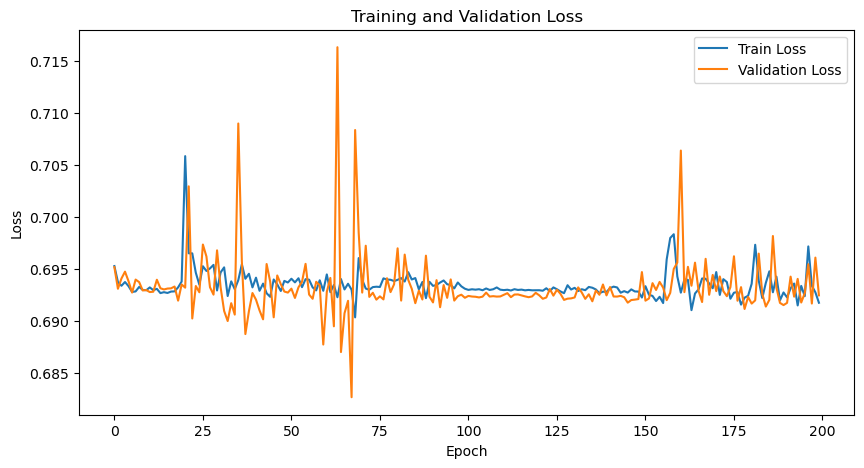

Epoch 20/200, Train Loss: 0.6914, Val Loss: 0.6936
Epoch 40/200, Train Loss: 0.6931, Val Loss: 0.6936
Epoch 60/200, Train Loss: 0.6931, Val Loss: 0.6922
Epoch 80/200, Train Loss: 0.6930, Val Loss: 0.6927
Epoch 100/200, Train Loss: 0.6945, Val Loss: 0.6927
Epoch 120/200, Train Loss: 0.6931, Val Loss: 0.6928
Epoch 140/200, Train Loss: 0.6931, Val Loss: 0.6924
Epoch 160/200, Train Loss: 0.6930, Val Loss: 0.6925
Epoch 180/200, Train Loss: 0.6929, Val Loss: 0.6925
Epoch 200/200, Train Loss: 0.6928, Val Loss: 0.6926
The function took 387.3204 seconds to execute.


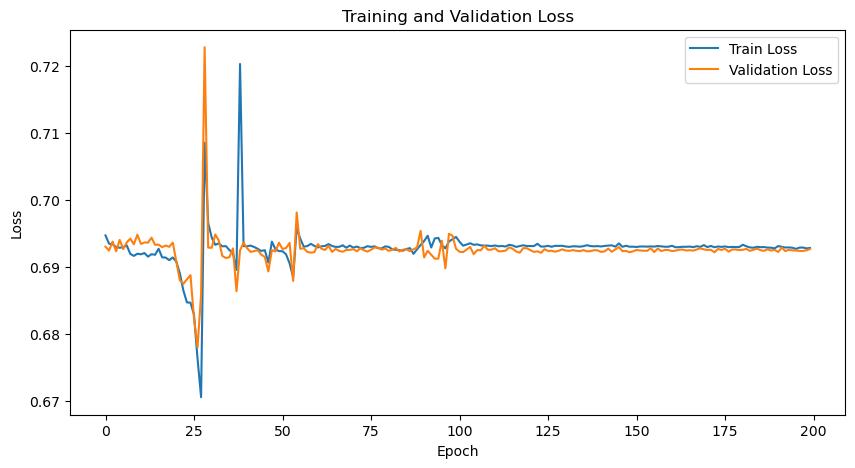

Epoch 20/200, Train Loss: 0.6929, Val Loss: 0.6930
Epoch 40/200, Train Loss: 0.6928, Val Loss: 0.6932
Epoch 60/200, Train Loss: 0.6942, Val Loss: 0.6932
Epoch 80/200, Train Loss: 0.6959, Val Loss: 0.6930
Epoch 100/200, Train Loss: 0.6963, Val Loss: 0.6916
Epoch 120/200, Train Loss: 0.6938, Val Loss: 0.6928
Epoch 140/200, Train Loss: 0.6945, Val Loss: 0.6935
Epoch 160/200, Train Loss: 0.6929, Val Loss: 0.6935
Epoch 180/200, Train Loss: 0.6953, Val Loss: 0.6966
Epoch 200/200, Train Loss: 0.6949, Val Loss: 0.6938
The function took 389.4454 seconds to execute.


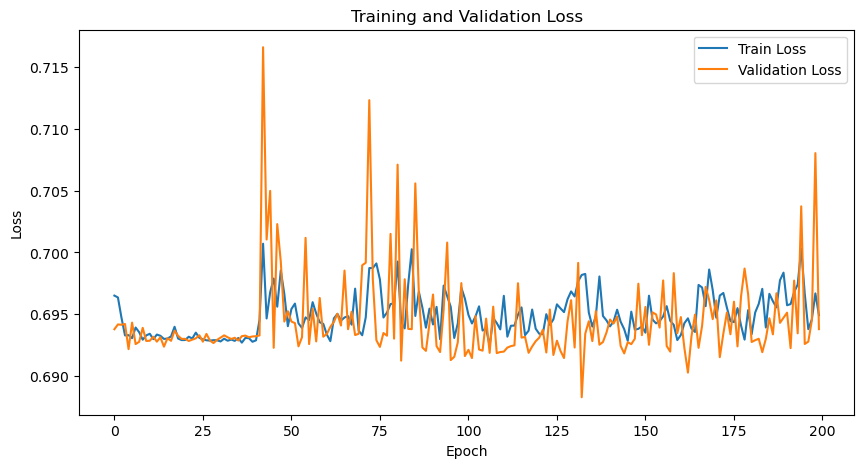

In [15]:
#Define the Loss function, the optimizers, the architectures and train the models
criterion = nn.CrossEntropyLoss()
# Define training parameters
num_epochs = 200

MonoRNNmodel = RNNClassifier(input_size=1, hidden_size=64, num_layers=2, num_classes=2).to(device)
optimizer = optim.Adam(MonoRNNmodel.parameters(), lr=0.001)
training_loop(MonoRNNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

LSTMmodel    = LSTMClassifier(input_size=1, hidden_size=64, num_layers=2, num_classes=2).to(device)
optimizer = optim.Adam(LSTMmodel.parameters(), lr=0.001)
training_loop(LSTMmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

BiRNNmodel   = BiRNNClassifier(input_size=1, hidden_size=64, num_layers=2, num_classes=2).to(device)
optimizer = optim.Adam(BiRNNmodel.parameters(), lr=0.001)
training_loop(BiRNNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

MonoRNNmodel


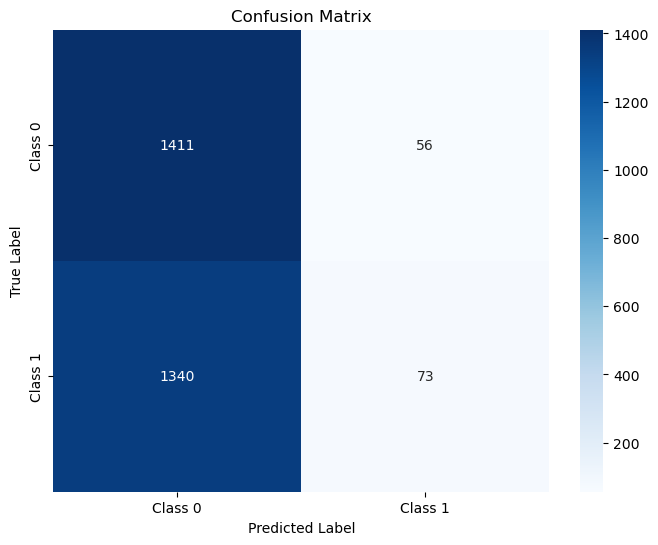

The function took 0.6202 seconds to execute.
Train Accuracy: 51.5278


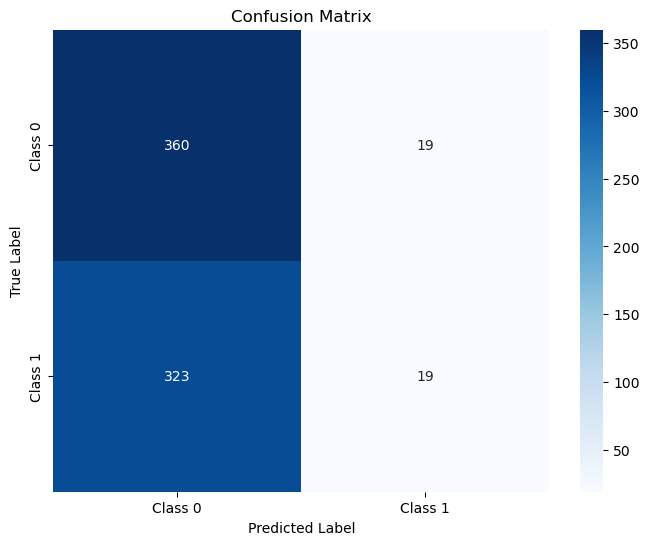

The function took 0.2625 seconds to execute.
Validation Accuracy: 52.5659


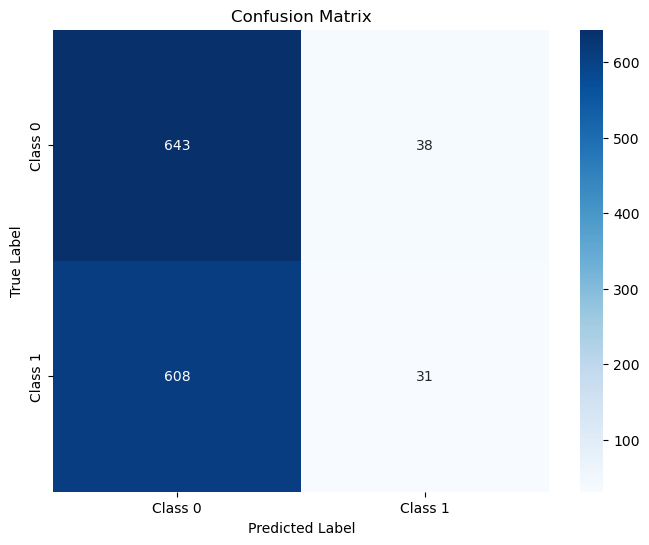

The function took 0.3540 seconds to execute.
Test Accuracy: 51.0606
LSTMmodel


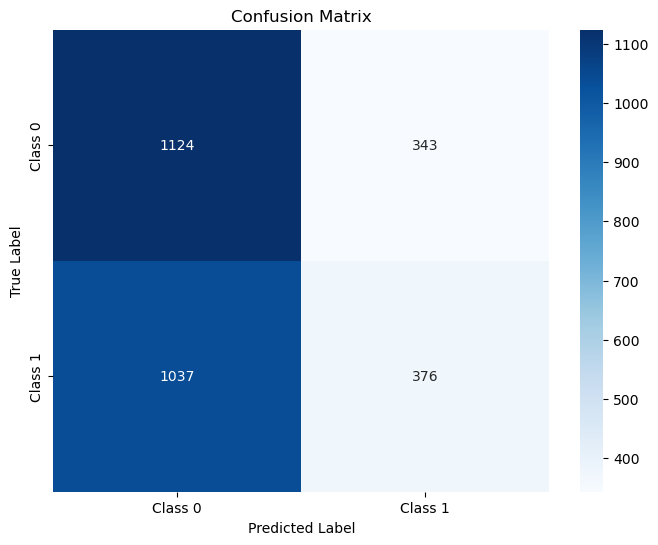

The function took 0.7759 seconds to execute.
Train Accuracy: 52.0833


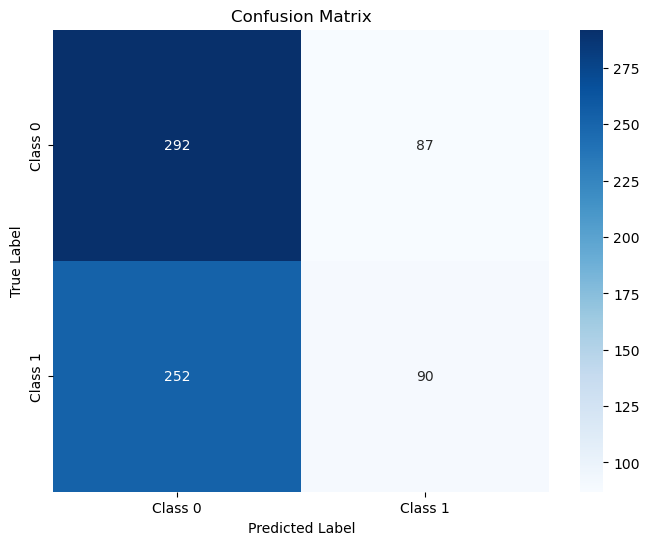

The function took 0.3058 seconds to execute.
Validation Accuracy: 52.9820


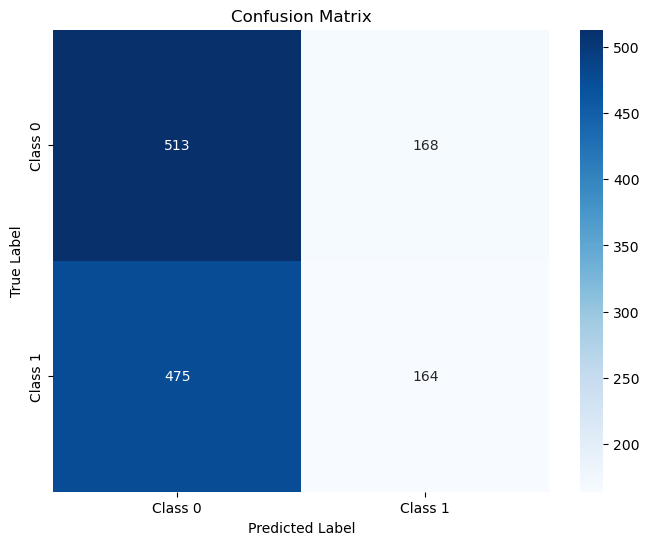

The function took 0.4252 seconds to execute.
Test Accuracy: 51.2879
BiRNNmodel


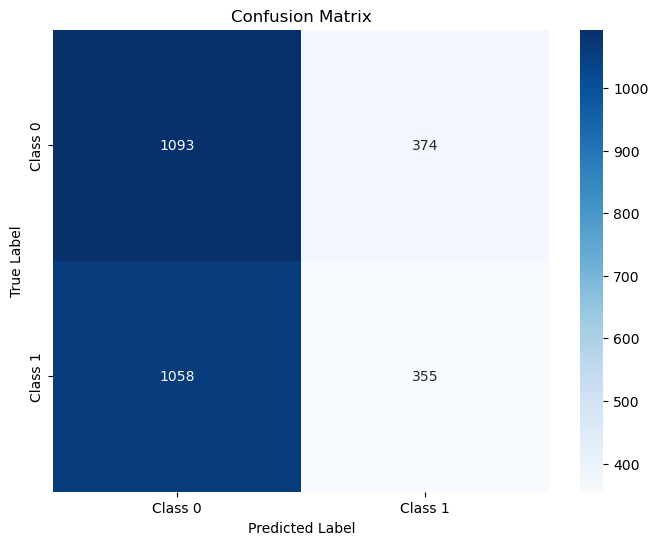

The function took 0.9439 seconds to execute.
Train Accuracy: 50.2778


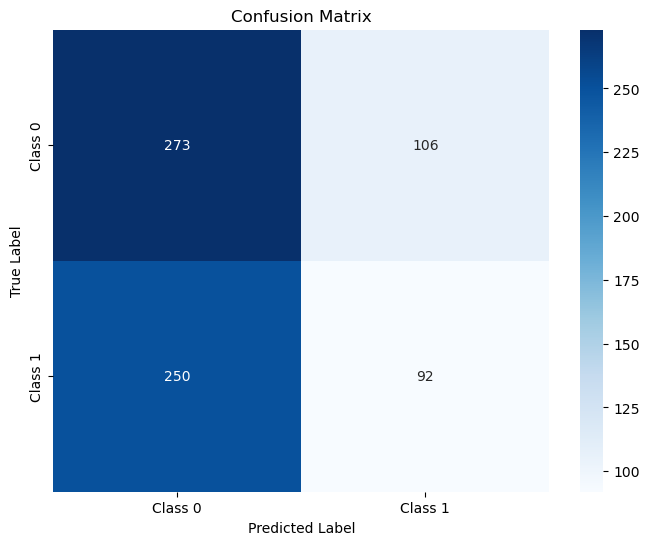

The function took 0.3486 seconds to execute.
Validation Accuracy: 50.6241


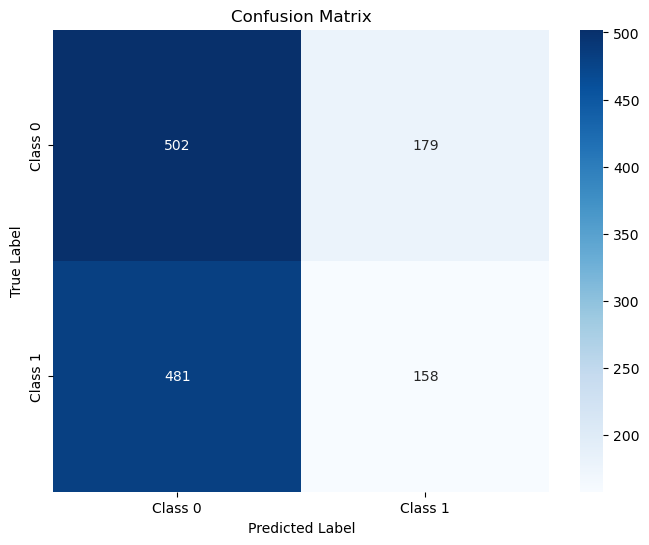

The function took 0.5054 seconds to execute.
Test Accuracy: 50.0000


In [16]:
#Test the models
model_names = ["MonoRNNmodel","LSTMmodel","BiRNNmodel"]
models = [MonoRNNmodel,LSTMmodel,BiRNNmodel]
for i in range(len(model_names)):
    model = models[i]
    print(model_names[i])
    train_accuracy = testing_model(model,train_loader,device)
    print(f'Train Accuracy: {train_accuracy:.4f}')
    val_accuracy = testing_model(model,val_loader,device)
    print(f'Validation Accuracy: {val_accuracy:.4f}')    
    test_accuracy = testing_model(model,test_loader,device)
    print(f'Test Accuracy: {test_accuracy:.4f}') 

cpu
The function took 179.9823 seconds to execute.


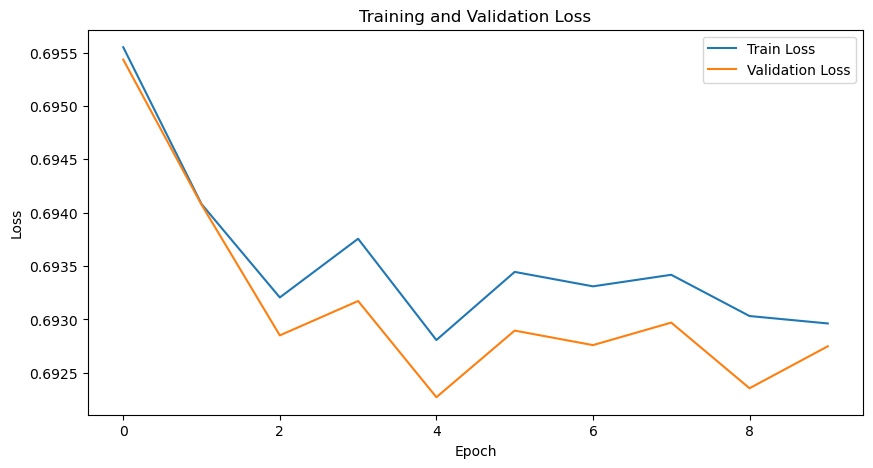

In [19]:
#Define the device to use for training and validation
device = "cpu"
print(device)
#Define the Loss function, the optimizers, the architectures and train the models
criterion = nn.CrossEntropyLoss()
# Define training parameters
num_epochs = 10

CPU_MonoRNNmodel = RNNClassifier(input_size=1, hidden_size=64, num_layers=2, num_classes=2).to(device)
optimizer = optim.Adam(CPU_MonoRNNmodel.parameters(), lr=0.001)
training_loop(CPU_MonoRNNmodel, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs, criterion)

**Notice**: 
  - With **GPU** and **200 epochs** the function took: **263.2416 seconds** to execute.
  - With **CPU** and **10 epochs**  the function took: **179.9823 seconds** to execute.

With a real dataset GPU helps a lot!